<img src="./images/stocks.jpg"></img>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li><li><span><a href="#Split-Into-Training-Set-and-a-Test-set" data-toc-modified-id="Split-Into-Training-Set-and-a-Test-set-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Split Into Training Set and a Test set</a></span></li><li><span><a href="#Normalizing-The-Data" data-toc-modified-id="Normalizing-The-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Normalizing The Data</a></span></li><li><span><a href="#One-Step-Ahead-Prediction-via-Averaging" data-toc-modified-id="One-Step-Ahead-Prediction-via-Averaging-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>One-Step Ahead Prediction via Averaging</a></span><ul class="toc-item"><li><span><a href="#Standard-Average" data-toc-modified-id="Standard-Average-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Standard Average</a></span></li><li><span><a href="#Exponential-Moving-Average" data-toc-modified-id="Exponential-Moving-Average-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Exponential Moving Average</a></span></li></ul></li><li><span><a href="#Prediction-With-LSTM-Network" data-toc-modified-id="Prediction-With-LSTM-Network-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Prediction With LSTM Network</a></span><ul class="toc-item"><li><span><a href="#Common-Functions:" data-toc-modified-id="Common-Functions:-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Common Functions:</a></span></li><li><span><a href="#Spliting-The-Dataset-Into-Train,-CV-and-Test" data-toc-modified-id="Spliting-The-Dataset-Into-Train,-CV-and-Test-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Spliting The Dataset Into Train, CV and Test</a></span></li><li><span><a href="#Standardization-of-Train-and-CV-Dataset" data-toc-modified-id="Standardization-of-Train-and-CV-Dataset-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Standardization of Train and CV Dataset</a></span></li><li><span><a href="#Building-And-Training-The-LSTM-Network" data-toc-modified-id="Building-And-Training-The-LSTM-Network-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Building And Training The LSTM Network</a></span></li><li><span><a href="#Prediction-on-CV-Dataset" data-toc-modified-id="Prediction-on-CV-Dataset-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Prediction on CV Dataset</a></span></li><li><span><a href="#Tuning-N-(no.-of-days-to-use-as-features)" data-toc-modified-id="Tuning-N-(no.-of-days-to-use-as-features)-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Tuning N (no. of days to use as features)</a></span></li><li><span><a href="#Tuning-Model---epochs-and-batch_size" data-toc-modified-id="Tuning-Model---epochs-and-batch_size-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>Tuning Model - epochs and batch_size</a></span></li><li><span><a href="#Tuning-Model---LSTM-Units-and-dropout-prob" data-toc-modified-id="Tuning-Model---LSTM-Units-and-dropout-prob-5.8"><span class="toc-item-num">5.8&nbsp;&nbsp;</span>Tuning Model - LSTM Units and dropout prob</a></span></li><li><span><a href="#Tuned-Parameters" data-toc-modified-id="Tuned-Parameters-5.9"><span class="toc-item-num">5.9&nbsp;&nbsp;</span>Tuned Parameters</a></span></li></ul></li><li><span><a href="#Final-Model" data-toc-modified-id="Final-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Final Model</a></span></li></ul></div>

In [1]:
import warnings
warnings.filterwarnings('ignore')
%config IPCompleter.use_jedi = False

import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from datetime import date
from tqdm import tqdm_notebook 
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

################ Constants #######################
TEST_SIZE = 0.2          # Proportion of dataset to be used as test set
CV_SIZE = 0.2            # Proportion of dataset to be used as cross validation set
window_size = 21         # for feature at day t, we use lags from t-1, t-2, ..... t-WINDOW as feature or lookback period
                         
smooth_window_size = 250 # Smoothing Winow Size
EMA = 0.0                # Exponential Moving Average
GAMMA = 0.1              # Factor To Calculate Moving Average

N = 9                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. (it is same as window 
                               # size but for LSTM we will be using this size as 9)
    
                               # initial value before tuning
lstm_units=50                  # lstm param. initial value before tuning.
dropout_prob=0.5               # lstm param. initial value before tuning.
optimizer='adam'               # lstm param. initial value before tuning.
epochs=10                      # lstm param. initial value before tuning.
batch_size=20                  # lstm param. initial value before tuning.
##################################################

prices.csv and prices-split-adjusted.csv are same dataset but prices-split-adjusted.csv contains additional information about the stock splits at that time so we will use second dataset for exploration. 

## Exploratory Data Analysis

In [2]:
prices_df = pd.read_csv('Datasets/prices.csv')
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [3]:
prices_split_df = pd.read_csv('Datasets/prices-split-adjusted.csv', index_col='date', parse_dates=['date'])
prices_split_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


In [4]:
prices_split_df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [5]:
sec_fillings_df = pd.read_csv('Datasets/fundamentals.csv', parse_dates=['Period Ending'])
del sec_fillings_df['Unnamed: 0']
sec_fillings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 78 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   Ticker Symbol                                        1781 non-null   object        
 1   Period Ending                                        1781 non-null   datetime64[ns]
 2   Accounts Payable                                     1781 non-null   float64       
 3   Accounts Receivable                                  1781 non-null   float64       
 4   Add'l income/expense items                           1781 non-null   float64       
 5   After Tax ROE                                        1781 non-null   float64       
 6   Capital Expenditures                                 1781 non-null   float64       
 7   Capital Surplus                                      1781 non-null   float64       
 8 

In [6]:
securities_df = pd.read_csv('Datasets/securities.csv')
securities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Ticker symbol            505 non-null    object
 1   Security                 505 non-null    object
 2   SEC filings              505 non-null    object
 3   GICS Sector              505 non-null    object
 4   GICS Sub Industry        505 non-null    object
 5   Address of Headquarters  505 non-null    object
 6   Date first added         307 non-null    object
 7   CIK                      505 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 31.7+ KB


Now let's find how many companies are there in the datset

In [7]:
securities_df.head()

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877


In [8]:
print('There are {} no of unique companies presents in the dataset'.format(prices_split_df['symbol'].nunique()))

There are 501 no of unique companies presents in the dataset


In [9]:
## Date range of the stock data
min_date, max_date = min(prices_df['date']), max(prices_df['date'])
print(f"Stoke data present from year {pd.Timestamp(min_date).year} to {pd.Timestamp(max_date).year}")

Stoke data present from year 2010 to 2016


In [10]:
securities_df[securities_df['Ticker symbol'] == 'AAPL'].head()

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
45,AAPL,Apple Inc.,reports,Information Technology,Computer Hardware,"Cupertino, California",1982-11-30,320193


In [11]:
aapl = prices_split_df[prices_split_df['symbol'] == 'AAPL']

In [12]:
min(aapl.index), max(aapl.index)

(Timestamp('2010-01-04 00:00:00'), Timestamp('2016-12-30 00:00:00'))

In [13]:
aapl.shape

(1762, 6)

In [14]:
aapl.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0
2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0
2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0
2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0


In [15]:
train_set = aapl[:int(aapl.shape[0] * 0.6)]
validation_set = aapl[int(aapl.shape[0] * 0.6):int(aapl.shape[0] * 0.6) + int(aapl.shape[0] * 0.2)]
test_set = aapl[int(aapl.shape[0] * 0.6) + int(aapl.shape[0] * 0.2):]

In [16]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1057 entries, 2010-01-04 to 2014-03-17
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  1057 non-null   object 
 1   open    1057 non-null   float64
 2   close   1057 non-null   float64
 3   low     1057 non-null   float64
 4   high    1057 non-null   float64
 5   volume  1057 non-null   float64
dtypes: float64(5), object(1)
memory usage: 57.8+ KB


In [17]:
print('Shape of training set: {}'.format(train_set.shape))
print('Shape of validation set: {}'.format(validation_set.shape))
print('Shape of test set: {}'.format(test_set.shape))

Shape of training set: (1057, 6)
Shape of validation set: (352, 6)
Shape of test set: (353, 6)


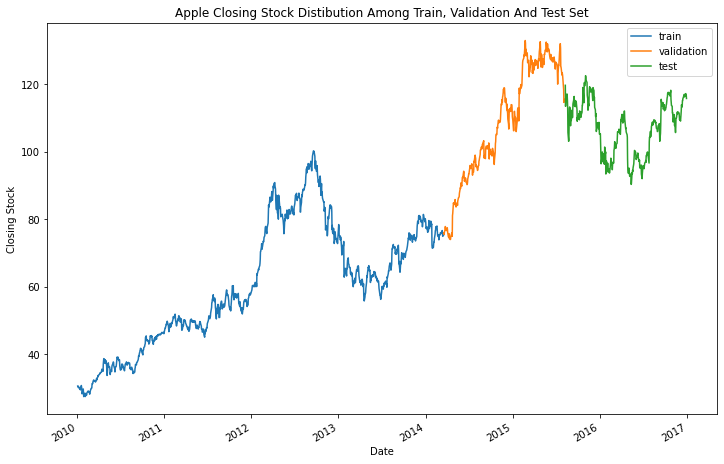

In [18]:
plt.figure(figsize=(12,8))
ax = train_set['close'].plot(label='train')
ax = validation_set['close'].plot(ax=ax, label='validation')
test_set['close'].plot(ax=ax, label='test')
plt.title('Apple Closing Stock Distibution Among Train, Validation And Test Set')
plt.xlabel('Date')
plt.ylabel('Closing Stock')
plt.legend()
plt.show()

In [19]:
securities_df.rename(columns={'Ticker symbol': 'Ticker Symbol'}, inplace=True)

In [20]:
# Merge sec_fillings_df with securities
sec_fillings_df = sec_fillings_df.merge(securities_df, on='Ticker Symbol')

In [21]:
# Create a new dataframe with fewer columns for analysis
listings_df = sec_fillings_df[['Ticker Symbol', 'Period Ending', 'Security', 'GICS Sector', 'Net Income']]
listings_df = listings_df.rename(columns={'Security': 'Company Name', 'GICS Sector': 'Sector'})
listings_df.head()

,Ticker Symbol,Period Ending,Company Name,Sector,Net Income
0,AAL,2012-12-31,American Airlines Group,Industrials,-1.876000e+09
1,AAL,2013-12-31,American Airlines Group,Industrials,-1.834000e+09
2,AAL,2014-12-31,American Airlines Group,Industrials,2.882000e+09
3,AAL,2015-12-31,American Airlines Group,Industrials,7.610000e+09
4,AAP,2012-12-29,Advance Auto Parts,Consumer Discretionary,3.876700e+08


In [22]:
## Let's find the name of different sectors 
all_sectors = listings_df['Sector'].unique().tolist()
print(f'List of all different sectors:\n {all_sectors}')

List of all different sectors:
 ['Industrials', 'Consumer Discretionary', 'Information Technology', 'Health Care', 'Consumer Staples', 'Utilities', 'Financials', 'Real Estate', 'Materials', 'Energy', 'Telecommunications Services']


Now let's find the top companies from different sectors:

In [23]:
listings_df.head()

,Ticker Symbol,Period Ending,Company Name,Sector,Net Income
0,AAL,2012-12-31,American Airlines Group,Industrials,-1.876000e+09
1,AAL,2013-12-31,American Airlines Group,Industrials,-1.834000e+09
2,AAL,2014-12-31,American Airlines Group,Industrials,2.882000e+09
3,AAL,2015-12-31,American Airlines Group,Industrials,7.610000e+09
4,AAP,2012-12-29,Advance Auto Parts,Consumer Discretionary,3.876700e+08


In [24]:
listing_by_netincome = pd.DataFrame(listings_df.groupby(['Ticker Symbol', 'Period Ending'])['Company Name', 
                                                                                            'Net Income', 'Sector'].max(), 
                                    columns=['Company Name', 'Net Income', 'Sector'])

In [25]:
listing_by_netincome

Company Name    Net Income  \
Ticker Symbol Period Ending                                          
AAL           2012-12-31     American Airlines Group -1.876000e+09   
              2013-12-31     American Airlines Group -1.834000e+09   
              2014-12-31     American Airlines Group  2.882000e+09   
              2015-12-31     American Airlines Group  7.610000e+09   
AAP           2012-12-29          Advance Auto Parts  3.876700e+08   
...                                              ...           ...   
ZION          2015-12-31               Zions Bancorp  3.094710e+08   
ZTS           2013-12-31                      Zoetis  5.040000e+08   
              2014-12-31                      Zoetis  5.830000e+08   
              2015-12-31                      Zoetis  3.390000e+08   
              2016-12-31                      Zoetis  8.210000e+08   

                                             Sector  
Ticker Symbol Period Ending                          
AAL           2012-12-31                Industrials  
              2013-12-31                Industrials  
              2014-12-31                Industrials  
              2015-12-31                Industrials  
AAP           2012-12-29     Consumer Discretionary  
...                                             ...  
ZION          2015-12-31                 Financials  
ZTS           2013-12-31                Health Care  
              2014-12-31                Health Care  
              2015-12-31                Health Care  
              2016-12-31                Health Care  

[1781 rows x 3 columns]

In [26]:
listing_by_netincome_2015 = listing_by_netincome.loc[pd.DatetimeIndex(
                            listing_by_netincome.index.get_level_values('Period Ending')).year == 2015]

listing_by_netincome_2015.index = listing_by_netincome_2015.index.droplevel('Period Ending')

In [27]:
listing_by_netincome_2015 = listing_by_netincome_2015.sort_values(by='Net Income', ascending=False)
listing_by_netincome_2015.head(10)

,Company Name,Net Income,Sector
Ticker Symbol,,,
AAPL,Apple Inc.,5.339400e+10,Information Technology
JPM,JPMorgan Chase & Co.,2.444200e+10,Financials
WFC,Wells Fargo,2.289400e+10,Financials
GILD,Gilead Sciences,1.810800e+10,Health Care
VZ,Verizon Communications,1.787900e+10,Telecommunications Services
C,Citigroup Inc.,1.724200e+10,Financials
WMT,Wal-Mart Stores,1.636300e+10,Consumer Staples
XOM,Exxon Mobil Corp.,1.615000e+10,Energy
BAC,Bank of America Corp,1.588800e+10,Financials


From the above dataframe it is clear that Apple got the highest Net income at the end of the year 2015 from IT sector and JP Morgan and Wells Fergo doing good from Financial Sectors.

Now let's find the total net income from all different sectors to have an idea of where to invest

In [29]:
listing_by_netincome_2015.groupby('Sector').sum()

,Net Income
Sector,
Consumer Discretionary,9.336904e+10
Consumer Staples,7.466840e+10
Energy,-6.220540e+10
Financials,1.583301e+11
Health Care,8.486874e+10
Industrials,9.929444e+10
Information Technology,1.588277e+11
Materials,9.919130e+09
Real Estate,1.532994e+10


In [28]:
sns.set_style('darkgrid')

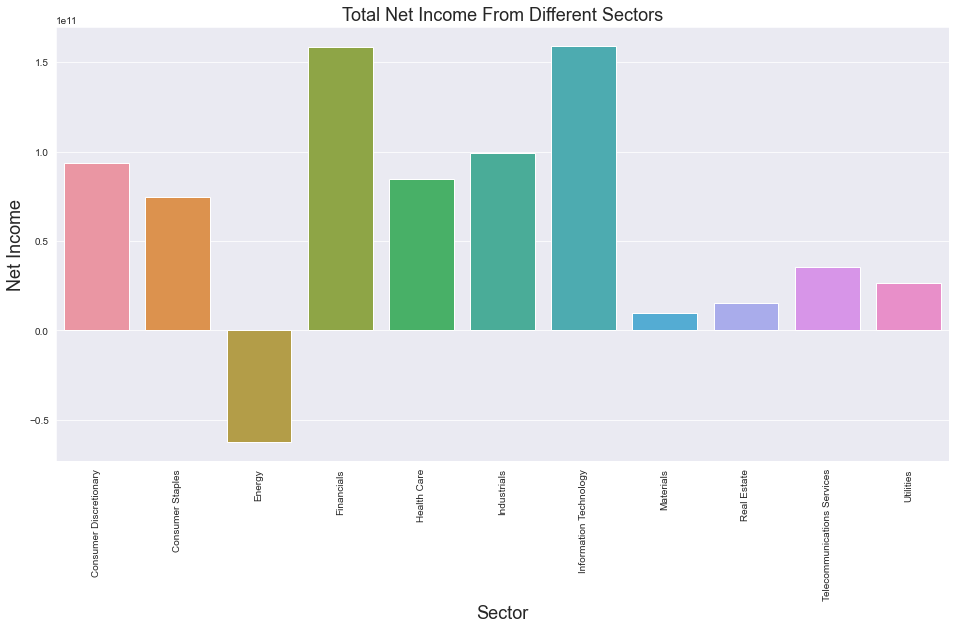

In [41]:
plt.figure(figsize=(16, 8))
df = listing_by_netincome_2015.groupby('Sector').sum()
sns.barplot(data=df, x=df.index, y='Net Income')
plt.xticks(rotation='vertical')
plt.xlabel('Sector', fontsize=18)
plt.ylabel('Net Income', fontsize=18)
plt.title('Total Net Income From Different Sectors', fontsize=18)
plt.show()

From the above plot we can see that most of the income coming from Financial and IT Sectors and also Investing in energy sectors have a high risk 

Now let's have a look on the trend of the stock of the target company that we are going to consider here which is the one of the best IT Sector Apple Inc. We will see the closing price trend of Apple Inc over the years 2010 to 2016 

In [28]:
aapl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  1762 non-null   object 
 1   open    1762 non-null   float64
 2   close   1762 non-null   float64
 3   low     1762 non-null   float64
 4   high    1762 non-null   float64
 5   volume  1762 non-null   float64
dtypes: float64(5), object(1)
memory usage: 96.4+ KB


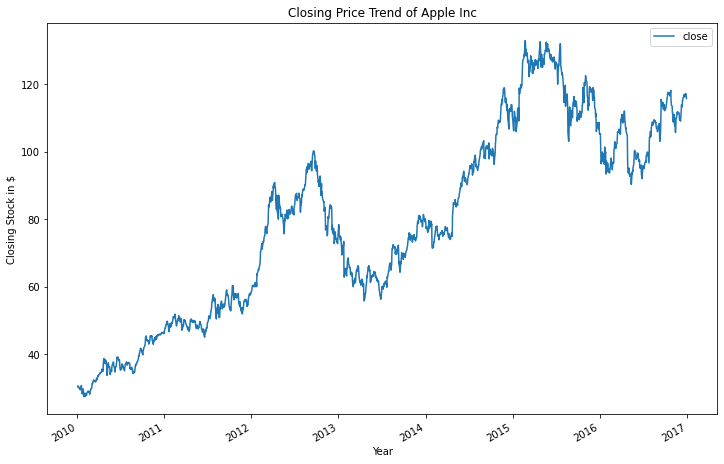

In [29]:
aapl[['close']].plot(figsize=(12,8))
plt.xlabel('Year')
plt.ylabel('Closing Stock in $')
plt.title('Closing Price Trend of Apple Inc')
plt.show()

We can see the sudden rise in between the year 2012 and 2013 and again in the year 2015 to 2016

Now we need to find different other IT sectors so that we can find some relatively correlated stock with Apple Inc and later on we will use that correlated company's stock to analyze the Apple stock. To do so we will select some of the well known IT sectors as bellow

In [30]:
## list IT Companies in the watchlist
watchlist = ['AAPL', 'AAL', 'YHOO', 'GOOG', 'MSFT', 'ADBE']

# Create an empty datframe with aapl index
it_companies_stocks_df = pd.DataFrame(index=aapl.index)
for ticker in watchlist:
    it_companies_stocks_df[ticker] = prices_split_df.loc[prices_split_df['symbol'] == ticker, 'close']

it_companies_stocks_df.head()

,AAPL,AAL,YHOO,GOOG,MSFT,ADBE
date,,,,,,
2010-01-04,30.572857,4.77,17.100000,312.205308,30.950001,37.090000
2010-01-05,30.625713,5.31,17.230000,310.830459,30.959999,37.700001
2010-01-06,30.138571,5.09,17.170000,302.994813,30.770000,37.619999
2010-01-07,30.082857,5.24,16.700001,295.941242,30.450001,36.889999
2010-01-08,30.282858,5.14,16.700001,299.886470,30.660000,36.689999


For finding the correlation we will use daily percentage change instead of directly using closing price as we can seen closing stock are in different scale.

In [31]:
it_companies_pct_return_df = it_companies_stocks_df.apply(lambda x: x.pct_change()[1:])
it_companies_pct_return_df.describe()

,AAPL,AAL,YHOO,GOOG,MSFT,ADBE
count,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000
mean,0.000893,0.001764,0.000647,0.000637,0.000502,0.000739
std,0.016518,0.030713,0.019162,0.015737,0.014607,0.017784
min,-0.123558,-0.158182,-0.087127,-0.083775,-0.113995,-0.190346
25%,-0.007550,-0.015152,-0.009837,-0.006928,-0.007415,-0.008056
50%,0.000759,0.001099,0.000545,0.000246,0.000000,0.000455
75%,0.010328,0.017517,0.011154,0.008456,0.008083,0.009676
max,0.088741,0.173167,0.103423,0.160524,0.104522,0.127801


In [32]:
# Find the correction matrix 
company_corr_df = it_companies_pct_return_df.corr()
company_corr_df

,AAPL,AAL,YHOO,GOOG,MSFT,ADBE
AAPL,1.000000,0.256286,0.306035,0.411582,0.389849,0.334466
AAL,0.256286,1.000000,0.275761,0.251567,0.273531,0.317640
YHOO,0.306035,0.275761,1.000000,0.423806,0.379028,0.383016
GOOG,0.411582,0.251567,0.423806,1.000000,0.470838,0.418770
MSFT,0.389849,0.273531,0.379028,0.470838,1.000000,0.468241
ADBE,0.334466,0.317640,0.383016,0.418770,0.468241,1.000000


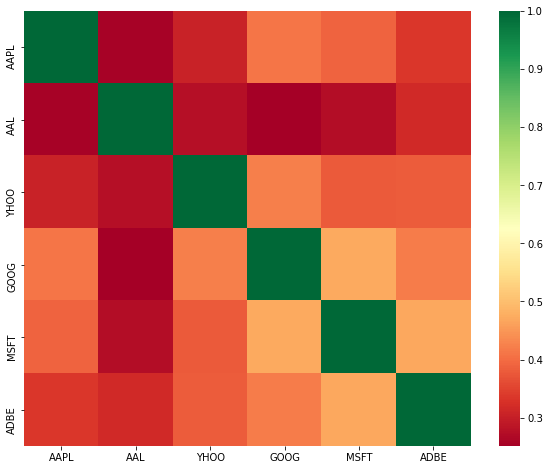

In [33]:
# Plot in heatmap
plt.figure(figsize=(10,8))
sns.heatmap(company_corr_df, cmap='RdYlGn')
plt.show()

Although we are not getting much correlated stock relative to Apple stock, we can consider google stock somewhat correlated to Apple's stock.

Now let's plot the google and apple closing price trend over the years 2010 to 2016

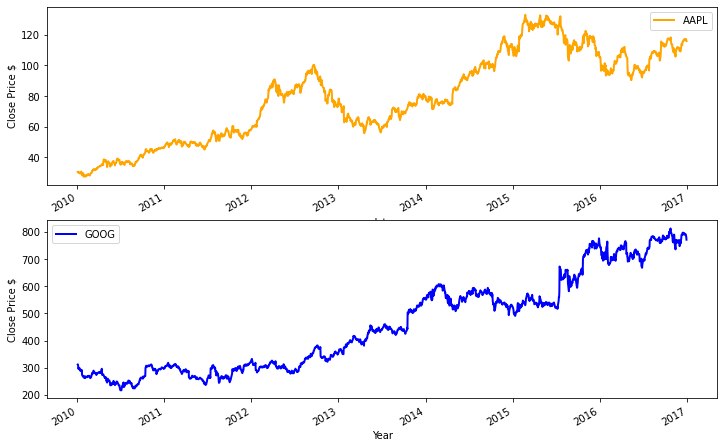

In [34]:
fig = plt.figure(figsize=(12,8))

# Add a subplot
ax1 = fig.add_subplot(211, ylabel='Close Price $')
it_companies_stocks_df['AAPL'].plot(ax=ax1, color='orange', lw=2, label='AAPL')
ax1.legend()

ax2 = fig.add_subplot(212, ylabel='Close Price $')
it_companies_stocks_df['GOOG'].plot(ax=ax2, color='blue', lw=2, label='GOOG')

ax2.legend()
plt.xlabel('Year')
plt.show()

## Split Into Training Set and a Test set

In [35]:
num_cv = int(CV_SIZE * len(aapl))
num_test = int(TEST_SIZE * len(aapl))
num_train = len(aapl) - num_test - num_cv

print('Number of train data: %d' % num_train)
print('Number of validation data: %d' % num_cv)
print('Number of test data: %d' % num_test)

# Split the dataset into train cv and test
train = aapl[:num_train]
cv = aapl[num_train:num_train+num_cv]
train_cv = aapl[:num_train+num_cv]
test = aapl[num_train+num_cv:]
print(f'Train Shape: {train.shape}')
print(f'Train CV Shape: {train_cv.shape}')
print(f'CV Shape: {cv.shape}')
print(f'Test Shape: {test.shape}')


# First Need to ensure stock data has been sorted by date index
aapl = aapl.sort_values('date')
closing_prices = aapl.loc[:, 'close'].to_numpy()

train_data = closing_prices[:1500]
test_data = closing_prices[1500:]

Number of train data: 1058
Number of validation data: 352
Number of test data: 352
Train Shape: (1058, 6)
Train CV Shape: (1410, 6)
CV Shape: (352, 6)
Test Shape: (352, 6)


## Normalizing The Data

Now we need to define a scaler to normalize the data. MinMaxScalar scales all the data to be in the region of 0 and 1. we can also reshape the training and test data to be in the shape [data_size, num_features].

In [36]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

# Train the scaler with training data and smooth the data
for di in range(0, train_data.size, smooth_window_size):
    train_data[di:di+smooth_window_size, :] = scaler.fit_transform(train_data[di:di+smooth_window_size, :])

# Reshape data back to the [data_size]
train_data = train_data.reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)

We can now smooth the data using the exponential moving average. This helps us to get rid of the inherent raggedness of the data in stock prices and produce a smoother curve.

**Note** that we should only smooth training data.

In [37]:
for ti in range(train_data.size):
    EMA = GAMMA * train_data[ti] + (1 - GAMMA) * EMA
    train_data[ti] = EMA
    
all_close_data = np.concatenate([train_data, test_data], axis=0)

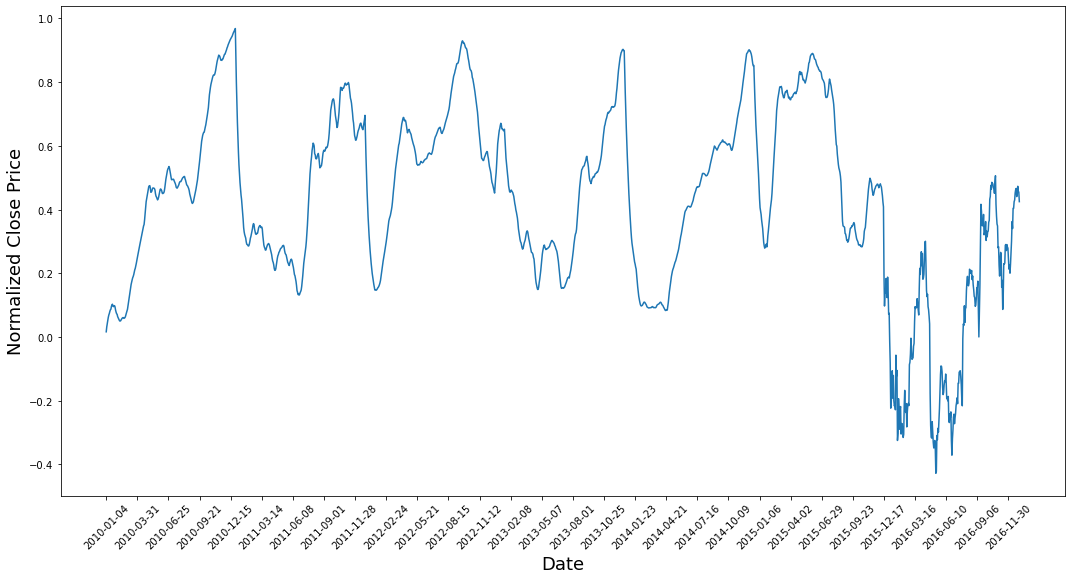

In [38]:
# Plot smoothed data using EMA
plt.figure(figsize=(18, 9))
plt.plot(range(0, all_close_data.shape[0]), all_close_data)
plt.xticks(range(0, aapl.shape[0], 60), aapl.index[::60].date, rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Normalized Close Price', fontsize=18)
plt.show()

## One-Step Ahead Prediction via Averaging
Averaging mechanisms allows us to predict (often one time step ahead) by representing the future stock price as an average of the previously observed stock prices. Doing this for more than one time step can produce quite bad results. We will apply at two averaging techniques below; standard averaging and exponential moving average. We will evaluate both qualitatively (visual inspection) and quantitatively (mean squared error) the results produced by two algorithms.

Mean squared error (MSE) can be calculated by taking the mean squared error between the true value at one step ahead and the predicted value and averaging it over all the predictions.

### Standard Average
Let us understand the difficulty of this problem first by trying to model this as an average calculation problem. That is first we will try to predict the future stock market prices (for example, $x_{t+1}$) as an average of the previously observed stock market prices within a fixed size window (for example, $x_{t-N},\ldots,x_{t}$) (say previous 21 days). Thereafter we will try a bit more fancier "exponential moving average" method and will see how well that does. Then we will move on to the "holy-grail" of time-series prediction; Long Short-Term Memory models.

First we will see how normal averaging works. That is we say,

$x_{t+1} = 1/N \sum_{i=t-N}^{t} x_i$

In other words, we say the prediction at $t+1$ is the average value of all the stock prices we observed withing a window of $t$ to $t-N$.

In [39]:
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size, train_data.size):
    date = aapl.index[pred_idx].date
    
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1] - train_data[pred_idx])**2)
    std_avg_x.append(date)
    
print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00513


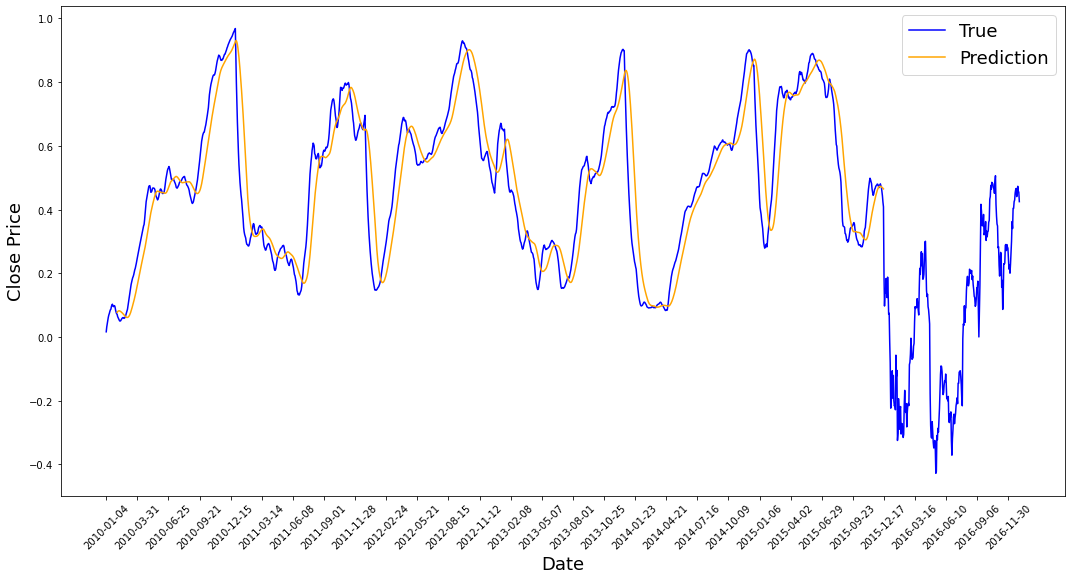

In [40]:
# Visualize one step ahead prediction using stand moving average
plt.figure(figsize=(18, 9))
plt.plot(range(aapl.shape[0]), all_close_data, color='b', label='True')
plt.plot(range(window_size, train_data.size), std_avg_predictions, color='orange', label='Prediction')
plt.xticks(range(0, aapl.shape[0], 60), aapl.index[::60].date, rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(fontsize=18)
plt.show()

It seems that it is not too bad of a model for very short predictions (one day ahead). Given that stock prices don't change from 0 to 21 overnight, this behavior is sensible. Next, we will look at a fancier averaging technique known as exponential moving average.

### Exponential Moving Average


In the exponential moving average method, we calculate $x_{t+1}$ as,

$x_{t+1} = EMA_{t} = \gamma \times EMA_{t-1} + (1-\gamma) x_t$ where $EMA_0 = 0$ and $EMA$ is the exponential moving average value we maintain over time.

The above equation basically calulates the exponential moving averag at $t+1$ time step and uses that as the one step ahead prediction. $\gamma$ decides what is the contribution of the most recent prediction to the EMA. For example, a $\gamma=0.1$ gets only 10% of the current value into the EMA. Because we take only a very small fraction of the most recent, it allows to preserve much older values we saw very early in the average. Let us look how good this looks when used to predict one-step ahead.

In [41]:
run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.1

for pred_idx in range(1,train_data.size):
    date = aapl.index[pred_idx].date

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00010


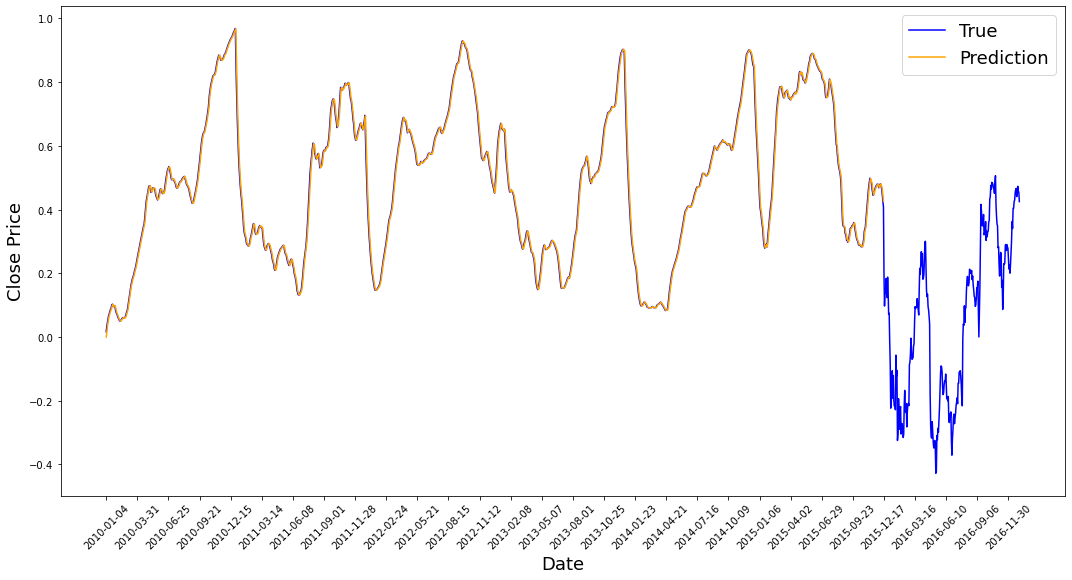

In [42]:
# Visualize one step ahead prediction using exponential moving average
plt.figure(figsize=(18, 9))
plt.plot(range(aapl.shape[0]), all_close_data, color='b', label='True')
plt.plot(range(0, train_data.size), run_avg_predictions, color='orange', label='Prediction')
plt.xticks(range(0, aapl.shape[0], 60), aapl.index[::60].date, rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(fontsize=18)
plt.show()

## Prediction With LSTM Network

We will be using few common functions for calculating metrics and scaling the datasets

### Common Functions:

In [43]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_x_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

def get_x_scaled_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    We scale x to have mean 0 and std dev 1, and return this.
    We do not scale y here.
    Inputs
        data     : pandas series to extract x and y
        N
        offset
    Outputs
        x_scaled : features used to predict y. Scaled such that each element has mean 0 and std dev 1
        y        : target values. Not scaled
        mu_list  : list of the means. Same length as x_scaled and y
        std_list : list of the std devs. Same length as x_scaled and y
    """
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i]-mu_list[i-offset])/std_list[i-offset])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list

def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv, \
                          mu_cv_list, \
                          std_cv_list, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=10, \
                          batch_size=20):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use LSTM here.
    Returns rmse, mape and predicted values
    Inputs
        x_train_scaled  : Here we are using the past N values to predict the next value (here N is 9)
        y_train_scaled  : e.g. y_train_scaled.shape=(1058, 1)
        x_cv_scaled     : use this to do predictions 
        y_cv            : actual value of the predictions
        mu_cv_list      : list of the means. Same length as x_scaled and y
        std_cv_list     : list of the std devs. Same length as x_scaled and y 
        lstm_units      : lstm param
        dropout_prob    : lstm param
        optimizer       : lstm param
        epochs          : lstm param
        batch_size      : lstm param
    Outputs
        rmse            : root mean square error
        mape            : mean absolute percentage error
        est             : predictions
    '''
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Do prediction
    est_scaled = model.predict(x_cv_scaled)
    est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
    
    # Calculate RMSE and MAPE
#     print("x_cv_scaled = " + str(x_cv_scaled))
#     print("est_scaled = " + str(est_scaled))
#     print("est = " + str(est))
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est

### Spliting The Dataset Into Train, CV and Test

In [44]:
# Split into train, cv, and test
train = aapl[:num_train][['close']]
cv = aapl[num_train:num_train+num_cv][['close']]
train_cv = aapl[:num_train+num_cv][['close']]
test = aapl[num_train+num_cv:][['close']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

train.shape = (1058, 1)
cv.shape = (352, 1)
train_cv.shape = (1410, 1)
test.shape = (352, 1)


### Standardization of Train and CV Dataset

In [45]:
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['close']).reshape(-1,1))
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))

# Split into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape)) 
print("y_train_scaled.shape = " + str(y_train_scaled.shape)) 

scaler.mean_ = [0.47248884]
scaler.var_ = [0.0548002]
x_train_scaled.shape = (1049, 9, 1)
y_train_scaled.shape = (1049, 1)


In [46]:
# Scale the cv dataset
# Split into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['close']).reshape(-1,1), N, num_train)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("len(mu_cv_list) = " + str(len(mu_cv_list)))
print("len(std_cv_list) = " + str(len(std_cv_list)))

x_cv_scaled.shape = (352, 9, 1)
y_cv.shape = (352, 1)
len(mu_cv_list) = 352
len(std_cv_list) = 352


In [47]:
# Here we scale the train_cv set, for the final model
scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['close']).reshape(-1,1))
print("scaler_final.mean_ = " + str(scaler_final.mean_))
print("scaler_final.var_ = " + str(scaler_final.var_))

# # Scale the test dataset
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(aapl['close']).reshape(-1,1), N, num_train+num_cv)
print("x_test_scaled.shape = " + str(x_test_scaled.shape))
print("y_test.shape = " + str(y_test.shape))
print("len(mu_test_list) = " + str(len(mu_test_list)))
print("len(std_test_list) = " + str(len(std_test_list)))

scaler_final.mean_ = [0.49914701]
scaler_final.var_ = [0.05725628]
x_test_scaled.shape = (352, 9, 1)
y_test.shape = (352, 1)
len(mu_test_list) = 352
len(std_test_list) = 352


### Building And Training The LSTM Network

In [48]:
# Create an LSTM Network
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1], 1)))
model.add(Dropout(dropout_prob))  # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob))  # Add dropout with a probability of 0.5
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/10
53/53 - 1s - loss: 0.2296
Epoch 2/10
53/53 - 0s - loss: 0.0946
Epoch 3/10
53/53 - 0s - loss: 0.0849
Epoch 4/10
53/53 - 0s - loss: 0.0738
Epoch 5/10
53/53 - 0s - loss: 0.0693
Epoch 6/10
53/53 - 0s - loss: 0.0680
Epoch 7/10
53/53 - 0s - loss: 0.0624
Epoch 8/10
53/53 - 0s - loss: 0.0500
Epoch 9/10
53/53 - 0s - loss: 0.0468
Epoch 10/10
53/53 - 0s - loss: 0.0466


In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 9, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 9, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


### Prediction on CV Dataset

In [50]:
# Do Prediction 
est_scaled = model.predict(x_cv_scaled)
est = (est_scaled * np.array(std_cv_list).reshape(-1, 1)) + np.array(mu_cv_list).reshape(-1, 1)
print(f'est.shape = {est.shape}')

# Calculate RMS 
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, est))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv, est)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

est.shape = (352, 1)
RMSE = 0.026
MAPE = 3.919%


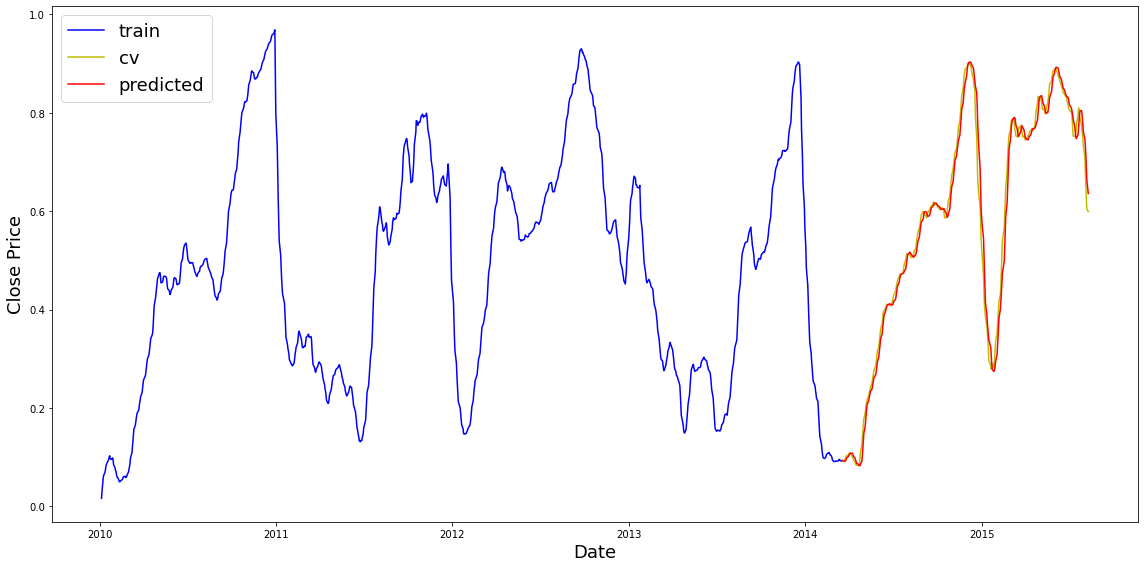

In [51]:
est_df = pd.DataFrame({'est': est.reshape(-1), 'y_cv': y_cv.reshape(-1)}, index=cv.index)


# Plot true and predicted closing price over time 
plt.figure(figsize=(16, 8))
plt.plot(train, 'b-', label='train')
plt.plot(cv, 'y-', label='cv')
# plt.plot(test, 'g-', label='test')
plt.plot(est_df[['est']], 'r-', label='predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()

In [52]:
est_df.head(10)

,est,y_cv
date,,
2014-03-19,0.093666,0.092559
2014-03-20,0.092965,0.091982
2014-03-21,0.092301,0.092714
2014-03-24,0.091943,0.095270
2014-03-25,0.092408,0.099310
2014-03-26,0.094191,0.101383
2014-03-27,0.096781,0.102553
2014-03-28,0.099418,0.103425
2014-03-31,0.101718,0.104175


### Tuning N (no. of days to use as features)

In [58]:
param_label = 'N'
param_range = range(3, 60)

error_rate = {param_label : [], 'rmse': [], 'mape': []}
tic = time.time()

for param in tqdm_notebook(param_range):
    
    # Split train into x and y
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)
    
    # Split cv into x and y
    x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['close']).reshape(-1,1), param, num_train)
    
    # train, predict and eval with LSTM model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, y_train_scaled,
                                          x_cv_scaled, y_cv, mu_cv_list, std_cv_list,
                                          lstm_units=lstm_units,
                                          dropout_prob=dropout_prob,
                                          optimizer=optimizer,
                                          epochs=epochs,
                                          batch_size=batch_size)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print('Minutes taken: {}'.format((toc - tic) / 60.0))
error_rate

  0%|          | 0/57 [00:00<?, ?it/s]

Minutes taken: 13.960609328746795


,N,rmse,mape
0,3,0.026234,3.941421
1,4,0.030624,4.589861
2,5,0.033245,5.005807
3,6,0.033178,4.986658
4,7,0.030785,4.646710
5,8,0.026828,4.089627
6,9,0.025951,3.941598
7,10,0.024648,3.731354
8,11,0.024779,3.750677
9,12,0.025026,3.777187


In [59]:
# Save error_rate dataframe to avoid repetative computation
error_rate.to_csv('Param_N_Error_Rate.csv')

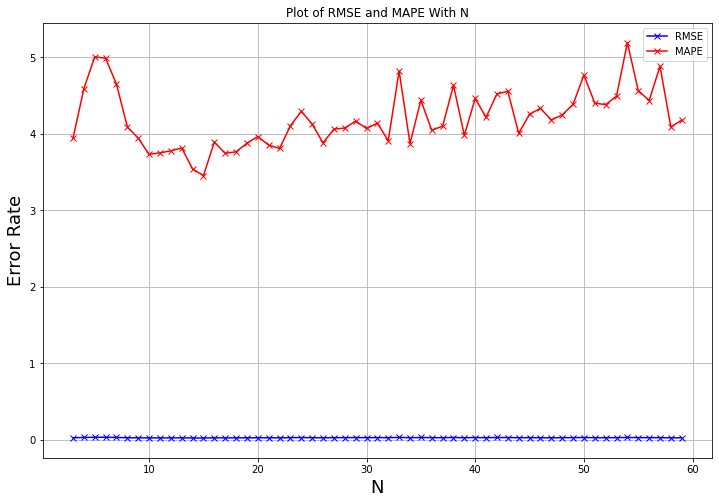

In [64]:
## Plot RMSE and MAPE
plt.figure(figsize=(12, 8))
plt.plot(error_rate[param_label], error_rate['rmse'], 'bx-', label='RMSE')
plt.plot(error_rate[param_label], error_rate['mape'], 'rx-', label='MAPE')
plt.xlabel('N', fontsize=18)
plt.ylabel('Error Rate', fontsize=18)
plt.title('Plot of RMSE and MAPE With N')
plt.grid(True)
plt.legend()
plt.show()

In [65]:
# Get optimum value for param
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 0.023
min MAPE = 3.453%
optimum N = 15


So the optimum value of N is 15

### Tuning Model - epochs and batch_size

In [69]:
param_label = 'epochs'
epochs_list = [10, 20, 30, 40, 50]

param_label1 = 'batch_size'
batch_size_list = [8, 16, 32, 64, 128]

# Split train into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

# Split cv into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['close']).reshape(-1,1), N_opt, num_train)

error_rate = {param_label : [], param_label1: [], 'rmse': [], 'mape': []}
tic = time.time()

for epoch in tqdm_notebook(epochs_list):
    
    for batch_len in tqdm_notebook(batch_size_list):
        # train, predict and eval with LSTM model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, y_train_scaled,
                                              x_cv_scaled, y_cv, mu_cv_list, std_cv_list,
                                              lstm_units=lstm_units,
                                              dropout_prob=dropout_prob,
                                              optimizer=optimizer,
                                              epochs=epoch,
                                              batch_size=batch_len)

        # Collect results
        error_rate[param_label].append(epoch)
        error_rate[param_label1].append(batch_len)                               
        error_rate['rmse'].append(rmse)
        error_rate['mape'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print('Minutes taken: {}'.format((toc - tic) / 60.0))
# Save error_rate dataframe to avoid repetative computation
error_rate.to_csv('Epochs_batch_tuning.csv')
error_rate

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Minutes taken: 8.56773093144099


,epochs,batch_size,rmse,mape
0,10,8,0.019538,2.923030
1,10,16,0.024082,3.600205
2,10,32,0.027613,4.119639
3,10,64,0.032966,4.867191
4,10,128,0.045336,6.760359
5,20,8,0.018654,2.694644
6,20,16,0.018646,2.634247
7,20,32,0.022340,3.368377
8,20,64,0.025815,3.898150
9,20,128,0.032163,4.815783


In [91]:
# param_label = 'epochs'
# epochs_list = [10, 20, 30, 40, 50]

# param_label1 = 'batch_size'
# batch_size_list = [8, 16, 32, 64, 128]

# error_rate = pd.read_csv('Epochs_batch_tuning.csv')
# del error_rate['Unnamed: 0']
# error_rate

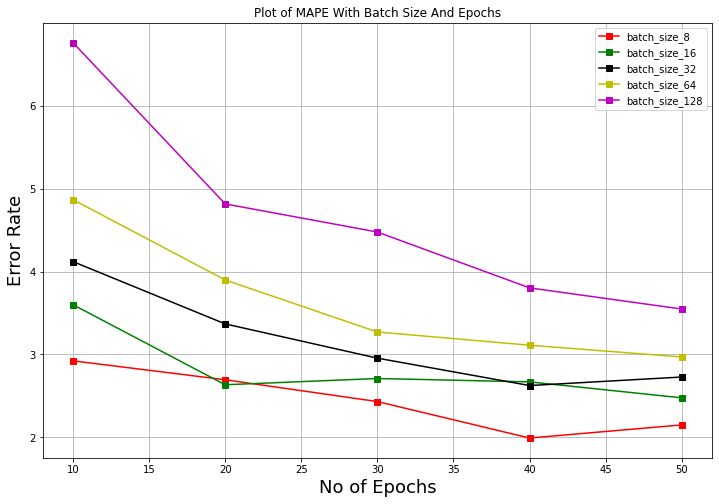

In [90]:
## Plot MAPE With Epochs and Batch_size
plt.figure(figsize=(12, 8))
color_list = ['r', 'g', 'k', 'y', 'm']

for i in range(len(batch_size_list)):
    plt.plot(epochs_list, error_rate.loc[error_rate[param_label1] == batch_size_list[i], 'mape'], 
             color_list[i % len(color_list)], marker='s', label='batch_size_' + str(batch_size_list[i]))
    
plt.xlabel('No of Epochs', fontsize=18)
plt.ylabel('Error Rate', fontsize=18)
plt.title('Plot of MAPE With Batch Size And Epochs')
plt.grid(True)
plt.legend()
plt.show()

In [78]:
# Get optimum value for batch_size and epoch
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param_label1].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param_label1 + " = " + str(batch_size_opt))

min RMSE = 0.014
min MAPE = 1.992%
optimum epochs = 40
optimum batch_size = 8


### Tuning Model - LSTM Units and dropout prob

In [80]:
param_label = 'lstm_units'
lstm_unit_list = [10, 50, 64, 128]

param_label1 = 'dropout_prob'
dropout_list = [0.5, 0.6, 0.7, 0.8]

# Split train into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

# Split cv into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['close']).reshape(-1,1), N_opt, num_train)

error_rate = {param_label : [], param_label1: [], 'rmse': [], 'mape': []}
tic = time.time()

for no_lstm_unit in tqdm_notebook(lstm_unit_list):
    
    for dropout in tqdm_notebook(dropout_list):
        # train, predict and eval with LSTM model
        print(f'Excuting For {no_lstm_unit} units and with dropout probability {dropout}')
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, y_train_scaled,
                                              x_cv_scaled, y_cv, mu_cv_list, std_cv_list,
                                              lstm_units=no_lstm_unit,
                                              dropout_prob=dropout,
                                              optimizer=optimizer,
                                              epochs=epochs_opt,
                                              batch_size=batch_size_opt)

        # Collect results
        error_rate[param_label].append(no_lstm_unit)
        error_rate[param_label1].append(dropout)                               
        error_rate['rmse'].append(rmse)
        error_rate['mape'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print('Minutes taken: {}'.format((toc - tic) / 60.0))
# Save error_rate dataframe to avoid repetative computation
error_rate.to_csv('lstm_unit_dropout_tuning.csv')
error_rate

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Excuting For 10 units and with dropout probability 0.5
Excuting For 10 units and with dropout probability 0.6
Excuting For 10 units and with dropout probability 0.7
Excuting For 10 units and with dropout probability 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

Excuting For 50 units and with dropout probability 0.5
Excuting For 50 units and with dropout probability 0.6
Excuting For 50 units and with dropout probability 0.7
Excuting For 50 units and with dropout probability 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

Excuting For 64 units and with dropout probability 0.5
Excuting For 64 units and with dropout probability 0.6
Excuting For 64 units and with dropout probability 0.7
Excuting For 64 units and with dropout probability 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

Excuting For 128 units and with dropout probability 0.5
Excuting For 128 units and with dropout probability 0.6
Excuting For 128 units and with dropout probability 0.7
Excuting For 128 units and with dropout probability 0.8
Minutes taken: 12.958400849501292


,lstm_units,dropout_prob,rmse,mape
0,10,0.5,0.026735,3.883675
1,10,0.6,0.029106,4.293985
2,10,0.7,0.034135,5.006735
3,10,0.8,0.041517,6.087672
4,50,0.5,0.015261,2.138918
5,50,0.6,0.017754,2.556892
6,50,0.7,0.020288,2.918407
7,50,0.8,0.023796,3.571112
8,64,0.5,0.015787,2.089525
9,64,0.6,0.018124,2.606043


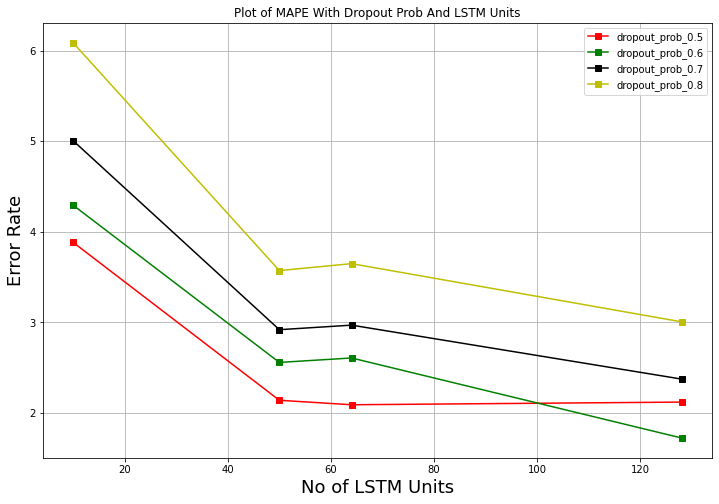

In [84]:
## Plot MAPE With LSTM units and dropout probabilities
plt.figure(figsize=(12, 8))
color_list = ['r', 'g', 'k', 'y', 'm']

for i in range(len(dropout_list)):
    plt.plot(lstm_unit_list, error_rate.loc[error_rate[param_label1] == dropout_list[i], 'mape'], 
             color_list[i % len(color_list)], marker='s', label='dropout_prob_' + str(dropout_list[i]))
    
plt.xlabel('No of LSTM Units', fontsize=18)
plt.ylabel('Error Rate', fontsize=18)
plt.title('Plot of MAPE With Dropout Prob And LSTM Units')
plt.grid(True)
plt.legend()
plt.show()

In [85]:
# Get optimum value for lstm units and dropout probs
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param_label1].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param_label1 + " = " + str(dropout_prob_opt))

min RMSE = 0.013
min MAPE = 1.722%
optimum lstm_units = 128
optimum dropout_prob = 0.6


### Tuned Parameters

In [93]:
d = {'param': ['N', 'lstm_units', 'dropout_prob', 'epochs', 'batch_size', 'rmse', 'mape'],
     'original': [N, lstm_units, dropout_prob, epochs, batch_size, rmse_bef_tuning, mape_pct_bef_tuning],
     'after_tuning': [N_opt, lstm_units_opt, dropout_prob_opt, epochs_opt, batch_size_opt, error_rate['rmse'].min(), 
                      error_rate['mape'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

,param,original,after_tuning
0,N,9.000000,15.000000
1,lstm_units,50.000000,128.000000
2,dropout_prob,0.500000,0.600000
3,epochs,10.000000,40.000000
4,batch_size,20.000000,8.000000
5,rmse,0.025866,0.014371
6,mape,3.919021,1.991873


## Final Model

In [96]:
# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, N_opt, N_opt)

# Split test into x and y
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(aapl['close']).reshape(-1,1), N_opt, 
                                                                    num_train+num_cv)

# Train, predict and eval model
rmse, mape, est = train_pred_eval_model(x_train_cv_scaled,
                                        y_train_cv_scaled,
                                        x_test_scaled,
                                        y_test,
                                        mu_test_list,
                                        std_test_list,
                                        lstm_units=lstm_units_opt,
                                        dropout_prob=dropout_prob_opt,
                                        optimizer=optimizer,
                                        epochs=epochs_opt,
                                        batch_size=batch_size_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 6.990
MAPE on test set = 2.399%


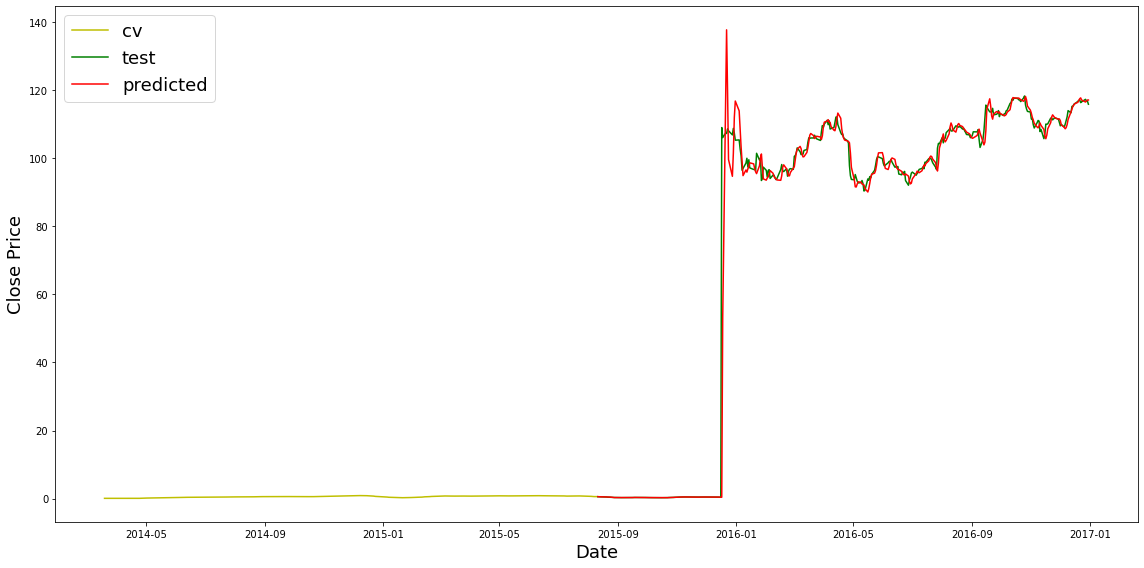

In [104]:
est_df = pd.DataFrame({'est': est.reshape(-1)}, index=aapl[num_train+num_cv:].index)


# Plot true and predicted closing price over time 
plt.figure(figsize=(16, 8))
plt.plot(cv, 'y-', label='cv')
plt.plot(test, 'g-', label='test')
plt.plot(est_df[['est']], 'r-', label='predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()

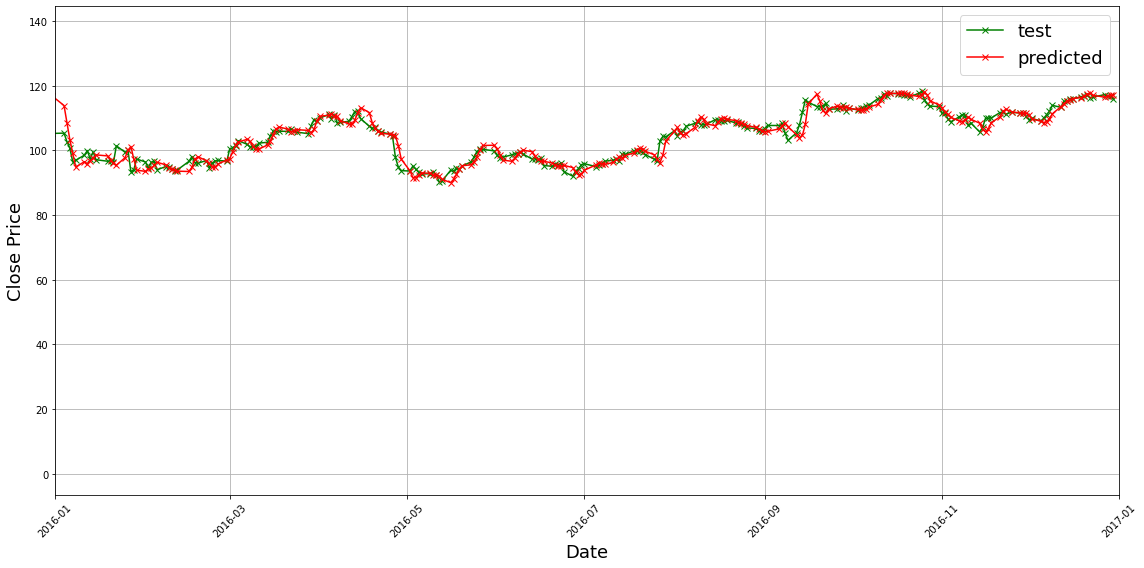

In [117]:
# Zoom on the test set
plt.figure(figsize=(16, 8))
# plt.plot(cv, 'y-', label='cv')
plt.plot(test, 'gx-', label='test')
plt.plot(est_df[['est']], 'rx-', label='predicted')
plt.xlim([date(2016, 1, 1), date(2017, 1, 1)])
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()

In [124]:
test_lstm = est_df
test_lstm.to_csv("stock_predicted_lstm.csv")